# PPO

In [1]:
import torch
import torch.nn as nn
import gymnasium as gym 
import numpy as np 

import torch.optim as optim

from sklearn.preprocessing import StandardScaler

# distribution functions 
from torch.distributions import Categorical 

from collections import defaultdict
import random
import torch.nn.functional as F


import sys
sys.path.append('../')


In [2]:
from collections import defaultdict
import numpy as np
import random
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

# Initialize the environment
env = gym.make("Blackjack-v1")
obs, info = env.reset()

# Set seed value for reproducibility
SEED = 3129
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define an Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, input_dim=3, action_dim=2):
        super(ActorCritic, self).__init__()
        # Shared network
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
        )
        # Actor head for policy logits
        self.actor = nn.Linear(32, action_dim)
        # Critic head for state-value
        self.critic = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.shared(x)
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

# Define the PPO Agent
class PPOAgent:
    def __init__(self, params):
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = ActorCritic(input_dim=3, action_dim=2).to(self.device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=params['lr'])
    
    def load_best_model(self, model_path='best_ppo_model.pth'):
        """Load the best saved model from disk."""
        self.policy.load_state_dict(torch.load(model_path, map_location=self.device))
        self.policy.eval()
        print(f"Loaded best model from {model_path}")


    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).to(self.device)
        logits, value = self.policy(state_tensor)
        probs = F.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, value

    def compute_returns(self, rewards, masks, values, next_value):
        """Compute the returns using the discount factor."""
        returns = []
        R = next_value
        # Iterate backwards over the trajectory
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.params['gamma'] * R * masks[step]
            returns.insert(0, R)
        return returns

    def ppo_update(self, trajectories):
        # Convert lists to tensors
        states = torch.FloatTensor(np.array(trajectories['states'])).to(self.device)
        actions = torch.LongTensor(trajectories['actions']).to(self.device)
        old_log_probs = torch.stack(trajectories['log_probs']).to(self.device).detach()
        returns = torch.FloatTensor(trajectories['returns']).to(self.device)
        # Compute advantage estimates: advantage = return - value
        values = torch.cat(trajectories['values']).squeeze().detach()
        advantages = returns - values

        # Perform multiple epochs of PPO updates
        for _ in range(self.params['ppo_epochs']):
            logits, value_estimates = self.policy(states)
            probs = F.softmax(logits, dim=-1)
            dist = Categorical(probs)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(actions)
            
            # Compute ratio (pi_theta / pi_theta_old)
            ratio = torch.exp(new_log_probs - old_log_probs)
            # Compute surrogate losses
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.params['clip'], 1 + self.params['clip']) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            # Critic loss (mean squared error)
            critic_loss = F.mse_loss(value_estimates.squeeze(), returns)
            loss = actor_loss + self.params['value_loss_coef'] * critic_loss - self.params['entropy_coef'] * entropy
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss.item()
    
    def get_value_policy_grid(self, usable_ace=False):
        """
        Generate grids for state value estimates and policy actions.
        The state is defined by (player_sum, dealer_card, usable_ace).
        
        Returns:
            value_grid: Tuple of (player_count, dealer_count, value) arrays.
            policy_grid: Array of best action (int) for each state.
        """
        # Create grids for player_sum (12-21) and dealer_card (1-10)
        player_count, dealer_count = np.meshgrid(
            np.arange(12, 22),
            np.arange(1, 11)
        )
        # Initialize arrays for value and policy
        value = np.zeros_like(player_count, dtype=float)
        policy_grid = np.zeros_like(player_count, dtype=int)
        
        # Loop over each state in the grid
        for i in range(player_count.shape[0]):
            for j in range(player_count.shape[1]):
                # Build state vector with the provided usable_ace flag
                state = np.array([player_count[i, j], dealer_count[i, j], float(usable_ace)])
                state_tensor = torch.FloatTensor(state).to(self.device)
                with torch.no_grad():
                    logits, value_est = self.policy(state_tensor)
                    probs = F.softmax(logits, dim=-1)
                # Record the state value and the best action
                value[i, j] = value_est.item()
                policy_grid[i, j] = int(torch.argmax(probs).item())
        
        value_grid = (player_count, dealer_count, value)
        return value_grid, policy_grid

In [57]:


# Hyperparameters for PPO
params = {
    'lr': 1e-3,
    'gamma': 0.99,
    'clip': 0.2,
    'ppo_epochs': 4,
    'value_loss_coef': 0.5,
    'entropy_coef': 0.01,
    'batch_size': 100,  # number of timesteps per update
    'max_episodes': 50000
}

agent = PPOAgent(params)

episode = 0
all_losses = []
best_avg_reward = -float('inf')  # Initialize best average reward as very low

while episode < params['max_episodes']:
    trajectories = {
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'masks': [],
        'values': []
    }
    timesteps = 0
    episode_rewards = []  # Track reward per episode in this batch
    current_episode_reward = 0

    # Collect trajectories until we have enough timesteps for an update
    while timesteps < params['batch_size']:
        state, _ = env.reset()
        done = False
        current_episode_reward = 0

        while not done and timesteps < params['batch_size']:
            action, log_prob, value = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition information
            trajectories['states'].append(state)
            trajectories['actions'].append(action)
            trajectories['log_probs'].append(log_prob)
            trajectories['rewards'].append(reward)
            trajectories['masks'].append(1 - float(done))
            trajectories['values'].append(value)
            
            current_episode_reward += reward
            state = next_state
            timesteps += 1

            if done:
                episode_rewards.append(current_episode_reward)
                episode += 1

    # Estimate value for the last state to bootstrap
    state_tensor = torch.FloatTensor(state).to(agent.device)
    with torch.no_grad():
        _, next_value = agent.policy(state_tensor)
    next_value = next_value.item()
    
    # Compute returns for the collected trajectory
    trajectories['returns'] = agent.compute_returns(
        trajectories['rewards'], trajectories['masks'], trajectories['values'], next_value
    )
    
    # Update the policy using PPO
    loss = agent.ppo_update(trajectories)
    all_losses.append(loss)
    
    # Calculate average reward for this batch
    avg_reward = np.mean(episode_rewards) if episode_rewards else 0.0
    print(f'Episode: {episode}, Loss: {loss:.4f}, Average Reward: {avg_reward:.4f}')
    
    # Save the model if the average reward is the best so far
    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        torch.save(agent.policy.state_dict(), 'best_ppo_model.pth')
        print(f'New best model saved with average reward: {best_avg_reward:.4f}')


Episode: 95, Loss: 0.3013, Average Reward: -0.1579
New best model saved with average reward: -0.1579
Episode: 187, Loss: 0.7720, Average Reward: -0.1522
New best model saved with average reward: -0.1522
Episode: 277, Loss: 0.3933, Average Reward: -0.1778
Episode: 371, Loss: 0.4117, Average Reward: -0.3617
Episode: 463, Loss: 0.2502, Average Reward: 0.0652
New best model saved with average reward: 0.0652
Episode: 554, Loss: 0.5012, Average Reward: -0.2527
Episode: 647, Loss: 0.4388, Average Reward: -0.0108
Episode: 730, Loss: 0.7380, Average Reward: -0.1687
Episode: 821, Loss: 0.6058, Average Reward: -0.2198
Episode: 908, Loss: 0.3306, Average Reward: -0.0460
Episode: 1001, Loss: 0.5134, Average Reward: -0.2581
Episode: 1097, Loss: 0.4960, Average Reward: -0.3125
Episode: 1188, Loss: 0.2873, Average Reward: -0.0549
Episode: 1280, Loss: 0.3776, Average Reward: -0.1848
Episode: 1375, Loss: 0.3909, Average Reward: -0.0632
Episode: 1469, Loss: 0.6781, Average Reward: -0.1489
Episode: 1561, 

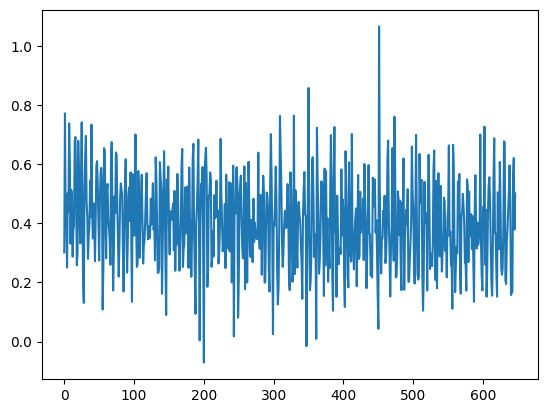

In [58]:
plt.plot(all_losses)

In [5]:

# Hyperparameters for PPO
params = {
    'lr': 1e-3,
    'gamma': 0.99,
    'clip': 0.2,
    'ppo_epochs': 4,
    'value_loss_coef': 0.5,
    'entropy_coef': 0.01,
    'batch_size': 100,  # number of timesteps per update
    'max_episodes': 50000
}

agent = PPOAgent(params)

agent.load_best_model('../checkpoints/best_ppo_model.pth')

Loaded best model from ../checkpoints/best_ppo_model.pth


In [11]:
from modules.utils import * 

value_grid, policy_grid = agent.get_value_policy_grid()
np.save('../checkpoints/PPO_No_Counting_Cards.npy', policy_grid)

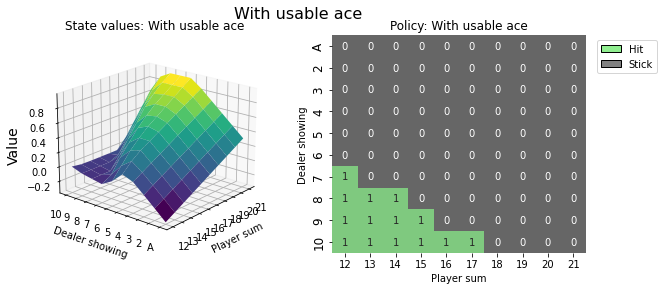

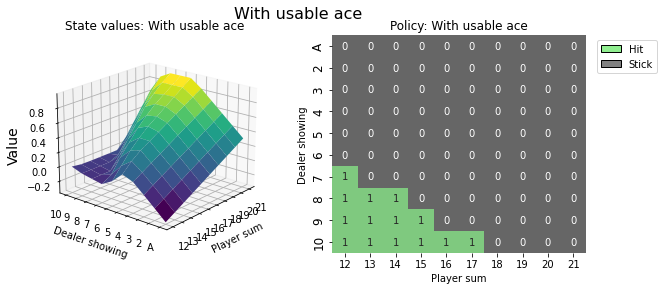

In [7]:
create_plots(value_grid, policy_grid, title="With usable ace")

In [10]:
# save to json
grid_to_policy_json(policy_grid, "../policies/PPO_No_Counting_Cards.json")


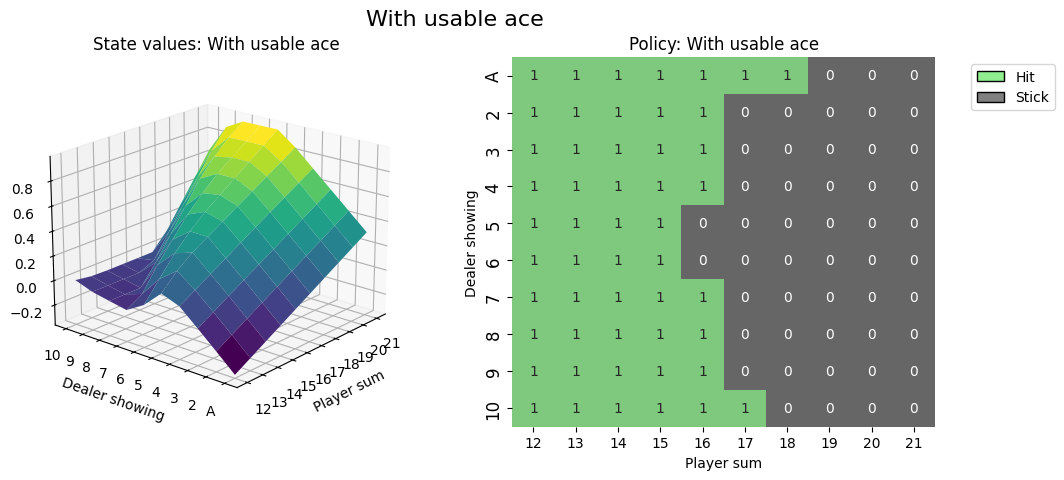

Policy matches basic strategy on 63/100 cells
Coverage: 63.00%


In [65]:
# Visualization (optional, requires matplotlib)
import matplotlib.pyplot as plt


basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])

fig = create_plots(value_grid, basic_strategy_grid, title="With usable ace")
plt.show()

coverage = policy_grid == basic_strategy_grid
coverage_pcnt = np.sum(coverage) / coverage.size * 100
print(f"Policy matches basic strategy on {np.sum(coverage)}/{coverage.size} cells")
print(f"Coverage: {coverage_pcnt:.2f}%")